# Setting everything up

In [ ]:
#This part fixes error when applying transforms to dataset (current bug with get_transforms())

!curl -s https://course.fast.ai/setup/colab | bash
!pip uninstall torch torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0

Updating fastai...
Done.
Uninstalling torch-1.4.0:
  Successfully uninstalled torch-1.4.0
Uninstalling torchvision-0.5.0:
  Successfully uninstalled torchvision-0.5.0
  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7e/90/6141bf41f5655c78e24f40f710fdd4f8a8aff6c8b7c6f0328240f649bdbe/torchvision-0.5.0-cp36-cp36m-manylinux1_x86_64.whl


In [ ]:
from fastai.vision import *

# Creating our own dataset

## Googliser 
Not as good as ImageNet (data has a lot of impurities, but more versitile - can use Google image search)
https://github.com/teracow/googliser

In [ ]:
#!apt-get update
#!apt install imagemagick
#!bash <(curl -skL git.io/get-googliser)

In [ ]:
#!googliser -p "canis lupus lupus" -n 64   <-Do this for every search term

## ImageNet
Note: A lot of ImageNet are from outside the synset, so they can only be found through URL tab on ImageNet website.

In [ ]:
import urllib.request

Note: This is the main input:
1. Choose classes
2. Find their respective links on ImageNet
3. Paste them here
4. Run the code without any further changes
5. You can change the name of the folder for the images if you want

In [ ]:
classes = ['Gray wolf', 
           'Arctic wolf',
           'Red wolf',
           'Coyote'
           ]
links = ['http://image-net.org/api/text/imagenet.synset.geturls?wnid=n02114367',
         'http://image-net.org/api/text/imagenet.synset.geturls?wnid=n02114548',
         'http://image-net.org/api/text/imagenet.synset.geturls?wnid=n02114712',
         'http://image-net.org/api/text/imagenet.synset.geturls?wnid=n02114855'
         ]

In [ ]:
dataset_folder_name = 'Wolves'

path = Path('data/'+dataset_folder_name)
path.mkdir(parents=True, exist_ok=True)

# Preparing the dataset

##Dowloading images

In [ ]:
for i in range(len(classes)):
  c = classes[i]
  link = links[i]

  urllib.request.urlretrieve(link, "data/"+dataset_folder_name+"/"+c+".txt")

  folder = c
  file_name = c+'.txt'

  path = Path('data/'+ dataset_folder_name)
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)

  download_images(path/file_name, dest, max_pics=256)
  verify_images(path/folder, delete=True, max_size=500)

In [ ]:
path = Path('data/'+ dataset_folder_name)

np.random.seed(123)

In [ ]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

##Example data

In [ ]:
data.classes

['Arctic wolf', 'Coyote', 'Gray wolf', 'Red wolf']

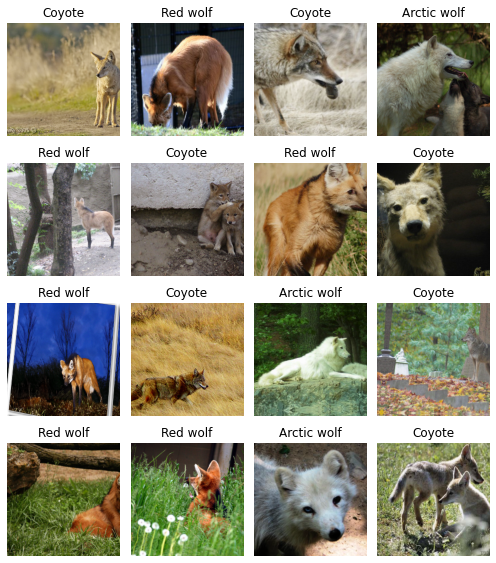

In [ ]:
data.show_batch(rows=4, figsize=(7,8))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Arctic wolf', 'Coyote', 'Gray wolf', 'Red wolf'], 4, 447, 111)

#Preparing the model

##Training the model

###Standard training

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.099601,0.914680,0.360360,01:51
1,1.414858,0.919350,0.216216,01:48
2,1.108250,0.855853,0.180180,01:47
3,0.913336,0.868848,0.180180,01:53
4,0.778694,0.879827,0.180180,01:47


In [ ]:
learn.save('stage-1')

###Fine-tuning

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


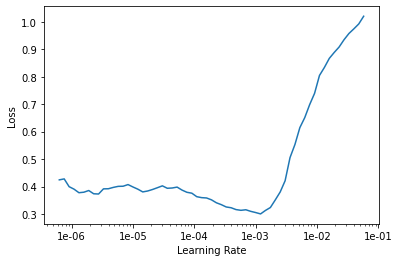

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(8e-5,6e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.432260,1.143601,0.234234,02:22
1,0.396329,1.461964,0.279279,02:21
2,0.336127,1.257636,0.270270,02:22


In [ ]:
learn.save('stage-2')

###Chosing the version with best efficiency 
Here the best effeciency on validation set I could get was before fine-tuning

In [ ]:
learn.load('stage-1')

##Visualizing results

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

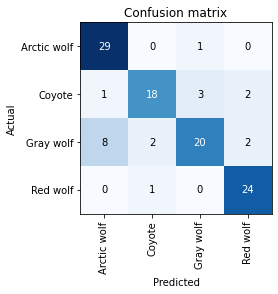

In [ ]:
interp.plot_confusion_matrix()

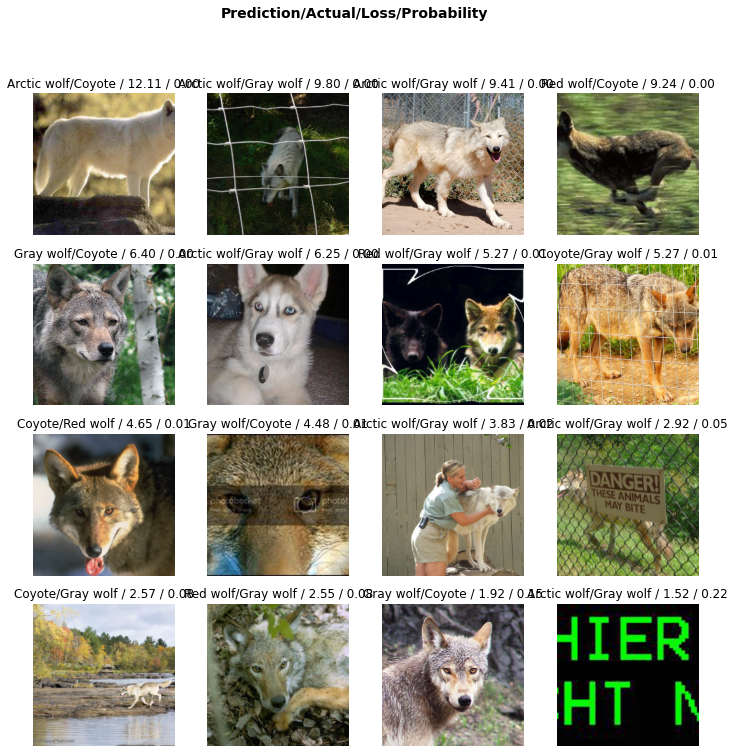

In [ ]:
interp.plot_top_losses(16)

#Production

##Exporting the model

In [ ]:
learn.export()

##Importing and setting up the model

At this point you will have a ready model in folder content/data/dataset_folder_name named export.pkl

The code from this point can be separated for the above given the file is in the corrrect directory (you may need to change the paths)

In [ ]:
model_path = Path("data/"+dataset_folder_name)
image_path = Path("test/img.jpeg")

img = open_image(image_path)

In [ ]:
defaults.device = torch.device('cpu')

In [ ]:
model = load_learner(model_path)

##Using the model

Arctic wolf


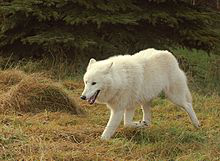

In [ ]:
print(model.data.classes[model.predict(img)[1].item()])
img